# !!! RUN VS CODE AS ADMINISTRATOR FOR TRACKMANIA NATIONS FOREVER !!!
# Otherwise, pydirectinput won't work and you'll cry (again).

# Libraries

In [4]:
# %pip install keyboard
# %pip install mss
# %pip install numpy
# %pip install matplotlib
# %pip install opencv-python

import pyautogui as py

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL as ImageGrab
import pyautogui as py
import pydirectinput
import keyboard

import os
import math
import time
import numpy
from mss import mss
import cv2
import numpy as np
import time
import pydirectinput
import threading
from datetime import datetime

import mss.tools  # Using mss.tools for safer access

In [5]:
# Edge Detection

In [6]:
import cv2 # Import the OpenCV library to enable computer vision
import numpy as np # Import the NumPy scientific computing library
import matplotlib.pyplot as plt # Used for plotting and error checking
 
def binary_array(array, thresh, value=0):
  """
  Return a 2D binary array (mask) in which all pixels are either 0 or 1
     
  :param array: NumPy 2D array that we want to convert to binary values
  :param thresh: Values used for thresholding (inclusive)
  :param value: Output value when between the supplied threshold
  :return: Binary 2D array...
           number of rows x number of columns = 
           number of pixels from top to bottom x number of pixels from
             left to right 
  """
  if value == 0:
    # Create an array of ones with the same shape and type as 
    # the input 2D array.
    binary = np.ones_like(array) 
         
  else:
    # Creates an array of zeros with the same shape and type as 
    # the input 2D array.
    binary = np.zeros_like(array)  
    value = 1
 
  # If value == 0, make all values in binary equal to 0 if the 
  # corresponding value in the input array is between the threshold 
  # (inclusive). Otherwise, the value remains as 1. Therefore, the pixels 
  # with the high Sobel derivative values (i.e. sharp pixel intensity 
  # discontinuities) will have 0 in the corresponding cell of binary.
  binary[(array >= thresh[0]) & (array <= thresh[1])] = value
 
  return binary
 
def blur_gaussian(channel, ksize=3):
  """
  Implementation for Gaussian blur to reduce noise and detail in the image
     
  :param image: 2D or 3D array to be blurred
  :param ksize: Size of the small matrix (i.e. kernel) used to blur
                i.e. number of rows and number of columns
  :return: Blurred 2D image
  """
  return cv2.GaussianBlur(channel, (ksize, ksize), 0)
         
def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
  """
  Implementation of Sobel edge detection
 
  :param image: 2D or 3D array to be blurred
  :param sobel_kernel: Size of the small matrix (i.e. kernel) 
                       i.e. number of rows and columns
  :return: Binary (black and white) 2D mask image
  """
  # Get the magnitude of the edges that are vertically aligned on the image
  sobelx = np.absolute(sobel(image, orient='x', sobel_kernel=sobel_kernel))
         
  # Get the magnitude of the edges that are horizontally aligned on the image
  sobely = np.absolute(sobel(image, orient='y', sobel_kernel=sobel_kernel))
 
  # Find areas of the image that have the strongest pixel intensity changes
  # in both the x and y directions. These have the strongest gradients and 
  # represent the strongest edges in the image (i.e. potential lane lines)
  # mag is a 2D array .. number of rows x number of columns = number of pixels
  # from top to bottom x number of pixels from left to right
  mag = np.sqrt(sobelx ** 2 + sobely ** 2)
 
  # Return a 2D array that contains 0s and 1s   
  return binary_array(mag, thresh)
 
def sobel(img_channel, orient='x', sobel_kernel=3):
  """
  Find edges that are aligned vertically and horizontally on the image
     
  :param img_channel: Channel from an image
  :param orient: Across which axis of the image are we detecting edges?
  :sobel_kernel: No. of rows and columns of the kernel (i.e. 3x3 small matrix)
  :return: Image with Sobel edge detection applied
  """
  # cv2.Sobel(input image, data type, prder of the derivative x, order of the
  # derivative y, small matrix used to calculate the derivative)
  if orient == 'x':
    # Will detect differences in pixel intensities going from 
        # left to right on the image (i.e. edges that are vertically aligned)
    sobel = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, sobel_kernel)
  if orient == 'y':
    # Will detect differences in pixel intensities going from 
    # top to bottom on the image (i.e. edges that are horizontally aligned)
    sobel = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, sobel_kernel)
 
  return sobel
 
def threshold(channel, thresh=(128,255), thresh_type=cv2.THRESH_BINARY):
  """
  Apply a threshold to the input channel
     
  :param channel: 2D array of the channel data of an image/video frame
  :param thresh: 2D tuple of min and max threshold values
  :param thresh_type: The technique of the threshold to apply
  :return: Two outputs are returned:
             ret: Threshold that was used
             thresholded_image: 2D thresholded data.
  """
  # If pixel intensity is greater than thresh[0], make that value
  # white (255), else set it to black (0)
  return cv2.threshold(channel, thresh[0], thresh[1], thresh_type)


# Sliding Window

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create edge detection module
class EdgeDetection:
    def threshold(self, img, thresh=(0, 255)):
        binary = np.zeros_like(img)
        binary[(img >= thresh[0]) & (img <= thresh[1])] = 255
        return True, binary

    def blur_gaussian(self, img, ksize=3):
        return cv2.GaussianBlur(img, (ksize, ksize), 0)

    def mag_thresh(self, img, sobel_kernel=3, thresh=(0, 255)):
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 255
        return binary_output

edge = EdgeDetection()
filename = 'D:/Thinkin in programming/Metopen/my_game_screenshots/Curved Line/screenshot_14.png'
 
class Lane:
  """
  Represents a lane on a road.
  """
  def __init__(self, orig_frame):
    """
      Default constructor
         
    :param orig_frame: Original camera image (i.e. frame)
    """
    self.orig_frame = orig_frame
 
    # This will hold an image with the lane lines       
    self.lane_line_markings = None
 
    # This will hold the image after perspective transformation
    self.warped_frame = None
    self.transformation_matrix = None
    self.inv_transformation_matrix = None
 
    # (Width, Height) of the original video frame (or image)
    self.orig_image_size = self.orig_frame.shape[::-1][1:]
 
    width = self.orig_image_size[0]
    height = self.orig_image_size[1]
    self.width = width
    self.height = height
     
    ''' Static ROI points.
      This ROI are based on the screen dimensions of 1920 x 1080 pixels. 
      The roi must satisfy the game screen dimensions.
    
    '''
    self.roi_points = np.float32([
    (250, 250),    # Top-left corner
     (600, 250),    # Top-right corner     
     (800, 300),    # Bottom-right corner
     (50,  300)    # Bottom-left corner    
    ])

    """
    Calculate ROI points based on screen dimensions
    Returns points in clockwise order: top-left, top-right, bottom-right, bottom-left
    """ 
    # # Define points as percentages of width and height
    # self.roi_points = np.float32([
    #     [width * 0.3, height * 0.5],    # Top-left (30% from left, 50% from top)
    #     [width * 0.7, height * 0.5],    # Top-right (70% from left, 50% from top)
    #     [width * 0.95, height * 0.7],   # Bottom-right (95% from left, 70% from top)
    #     [width * 0.05, height * 0.7]    # Bottom-left (5% from left, 70% from top)
    # ])
    
    # The desired corner locations  of the region of interest
    # after we perform perspective transformation.
    # Assume image width of 600, padding == 150.
    self.padding = int(0.25 * width) # padding from side of the image in pixels
    self.desired_roi_points = np.float32([
      [self.padding, 0], # Top-left corner
      [self.padding, self.orig_image_size[1]], # Bottom-left corner         
      [self.orig_image_size[
        0]-self.padding, self.orig_image_size[1]], # Bottom-right corner
      [self.orig_image_size[0]-self.padding, 0] # Top-right corner
    ]) 
         
    # Histogram that shows the white pixel peaks for lane line detection
    self.histogram = None
         
    # Sliding window parameters
    self.no_of_windows = 10
    self.margin = int((1/12) * width)  # Window width is +/- margin
    self.minpix = int((1/24) * width)  # Min no. of pixels to recenter window
         
    # Best fit polynomial lines for left line and right line of the lane
    self.left_fit = None
    self.right_fit = None
    self.left_lane_inds = None
    self.right_lane_inds = None
    self.ploty = None
    self.left_fitx = None
    self.right_fitx = None
    self.leftx = None
    self.rightx = None
    self.lefty = None
    self.righty = None
         
    # Pixel parameters for x and y dimensions
    self.YM_PER_PIX = 10.0 / 1000 # meters per pixel in y dimension
    self.XM_PER_PIX = 3.7 / 781 # meters per pixel in x dimension
         
    # Radii of curvature and offset
    self.left_curvem = None
    self.right_curvem = None
    self.center_offset = None
 
  def calculate_car_position(self, print_to_terminal=False):
    """
    Calculate the position of the car relative to the center
         
    :param: print_to_terminal Display data to console if True       
    :return: Offset from the center of the lane
    """
    # Assume the camera is centered in the image.
    # Get position of car in centimeters
    car_location = self.orig_frame.shape[1] / 2
 
    # Fine the x coordinate of the lane line bottom
    height = self.orig_frame.shape[0]
    bottom_left = self.left_fit[0]*height**2 + self.left_fit[
      1]*height + self.left_fit[2]
    bottom_right = self.right_fit[0]*height**2 + self.right_fit[
      1]*height + self.right_fit[2]
 
    center_lane = (bottom_right - bottom_left)/2 + bottom_left 
    center_offset = (np.abs(car_location) - np.abs(
      center_lane)) * self.XM_PER_PIX * 100
 
    if print_to_terminal == True:
      print(str(center_offset) + 'cm')
             
    self.center_offset = center_offset
       
    return center_offset
 
  def calculate_curvature(self, print_to_terminal=False):
    """
    Calculate the road curvature in meters.
 
    :param: print_to_terminal Display data to console if True
    :return: Radii of curvature
    """
    # Set the y-value where we want to calculate the road curvature.
    # Select the maximum y-value, which is the bottom of the frame.
    y_eval = np.max(self.ploty)    
 
    # Fit polynomial curves to the real world environment
    left_fit_cr = np.polyfit(self.lefty * self.YM_PER_PIX, self.leftx * (
      self.XM_PER_PIX), 2)
    right_fit_cr = np.polyfit(self.righty * self.YM_PER_PIX, self.rightx * (
      self.XM_PER_PIX), 2)
             
    # Calculate the radii of curvature
    left_curvem = ((1 + (2*left_fit_cr[0]*y_eval*self.YM_PER_PIX + left_fit_cr[
                    1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvem = ((1 + (2*right_fit_cr[
                    0]*y_eval*self.YM_PER_PIX + right_fit_cr[
                    1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Display on terminal window
    if print_to_terminal == True:
      print(left_curvem, 'm', right_curvem, 'm')
             
    self.left_curvem = left_curvem
    self.right_curvem = right_curvem
 
    return left_curvem, right_curvem        
         
  def calculate_histogram(self,frame=None,plot=True):
    """
    Calculate the image histogram to find peaks in white pixel count
         
    :param frame: The warped image
    :param plot: Create a plot if True
    """
    if frame is None:
      frame = self.warped_frame
             
    # Generate the histogram
    self.histogram = np.sum(frame[int(
              frame.shape[0]/2):,:], axis=0)
 
    if plot == True:
         
      # Draw both the image and the histogram
      figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
      figure.set_size_inches(10, 5)
      ax1.imshow(frame, cmap='gray')
      ax1.set_title("Warped Binary Frame")
      ax2.plot(self.histogram)
      ax2.set_title("Histogram Peaks")
      plt.show()
             
    return self.histogram
 
  def display_curvature_offset(self, frame=None, plot=False):
    """
    Display curvature and offset statistics on the image
         
    :param: plot Display the plot if True
    :return: Image with lane lines and curvature
    """
    image_copy = None
    if frame is None:
      image_copy = self.orig_frame.copy()
    else:
      image_copy = frame
 
    cv2.putText(image_copy,'Curve Radius: '+str((
      self.left_curvem+self.right_curvem)/2)[:7]+' m', (int((
      5/600)*self.width), int((
      20/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, (float((
      0.5/600)*self.width)),(
      255,255,255),2,cv2.LINE_AA)
    cv2.putText(image_copy,'Center Offset: '+str(
      self.center_offset)[:7]+' cm', (int((
      5/600)*self.width), int((
      40/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, (float((
      0.5/600)*self.width)),(
      255,255,255),2,cv2.LINE_AA)
             
    if plot==True:       
      cv2.imshow("Image with Curvature and Offset", image_copy)
 
    return image_copy
     
  def get_lane_line_previous_window(self, left_fit, right_fit, plot=False):
    """
    Use the lane line from the previous sliding window to get the parameters
    for the polynomial line for filling in the lane line
    :param: left_fit Polynomial function of the left lane line
    :param: right_fit Polynomial function of the right lane line
    :param: plot To display an image or not
    """
    # margin is a sliding window parameter
    margin = self.margin
 
    # Find the x and y coordinates of all the nonzero 
    # (i.e. white) pixels in the frame.         
    nonzero = self.warped_frame.nonzero()  
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
         
    # Store left and right lane pixel indices
    left_lane_inds = ((nonzerox > (left_fit[0]*(
      nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (
      nonzerox < (left_fit[0]*(
      nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(
      nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (
      nonzerox < (right_fit[0]*(
      nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))           
    self.left_lane_inds = left_lane_inds
    self.right_lane_inds = right_lane_inds
 
    # Get the left and right lane line pixel locations  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  
 
    self.leftx = leftx
    self.rightx = rightx
    self.lefty = lefty
    self.righty = righty        
     
    # Fit a second order polynomial curve to each lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    self.left_fit = left_fit
    self.right_fit = right_fit
         
    # Create the x and y values to plot on the image
    ploty = np.linspace(
      0, self.warped_frame.shape[0]-1, self.warped_frame.shape[0]) 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    self.ploty = ploty
    self.left_fitx = left_fitx
    self.right_fitx = right_fitx
         
    if plot==True:
         
      # Generate images to draw on
      out_img = np.dstack((self.warped_frame, self.warped_frame, (
                           self.warped_frame)))*255
      window_img = np.zeros_like(out_img)
             
      # Add color to the left and right line pixels
      out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
      out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [
                                                                     0, 0, 255]
      # Create a polygon to show the search window area, and recast 
      # the x and y points into a usable format for cv2.fillPoly()
      margin = self.margin
      left_line_window1 = np.array([np.transpose(np.vstack([
                                    left_fitx-margin, ploty]))])
      left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([
                                    left_fitx+margin, ploty])))])
      left_line_pts = np.hstack((left_line_window1, left_line_window2))
      right_line_window1 = np.array([np.transpose(np.vstack([
                                     right_fitx-margin, ploty]))])
      right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([
                                     right_fitx+margin, ploty])))])
      right_line_pts = np.hstack((right_line_window1, right_line_window2))
             
      # Draw the lane onto the warped blank image
      cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
      cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
      result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
       
      # Plot the figures 
      figure, (ax1, ax2, ax3) = plt.subplots(3,1) # 3 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
      ax1.imshow(cv2.cvtColor(self.orig_frame, cv2.COLOR_BGR2RGB))
      ax2.imshow(self.warped_frame, cmap='gray')
      ax3.imshow(result)
      ax3.plot(left_fitx, ploty, color='yellow')
      ax3.plot(right_fitx, ploty, color='yellow')
      ax1.set_title("Original Frame")  
      ax2.set_title("Warped Frame")
      ax3.set_title("Warped Frame With Search Window")
      plt.show()
             
  def get_lane_line_indices_sliding_windows(self, plot=False):
    """
    Get the indices of the lane line pixels using the 
    sliding windows technique.
         
    :param: plot Show plot or not
    :return: Best fit lines for the left and right lines of the current lane 
    """
    # Sliding window width is +/- margin
    margin = self.margin
 
    frame_sliding_window = self.warped_frame.copy()
 
    # Set the height of the sliding windows
    window_height = int(self.warped_frame.shape[0]/self.no_of_windows)       
 
    # Find the x and y coordinates of all the nonzero 
    # (i.e. white) pixels in the frame. 
    nonzero = self.warped_frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1]) 
         
    # Store the pixel indices for the left and right lane lines
    left_lane_inds = []
    right_lane_inds = []
         
    # Current positions for pixel indices for each window,
    # which we will continue to update
    leftx_base, rightx_base = self.histogram_peak()
    leftx_current = leftx_base
    rightx_current = rightx_base
 
    # Go through one window at a time
    no_of_windows = self.no_of_windows
         
    for window in range(no_of_windows):
       
      # Identify window boundaries in x and y (and right and left)
      win_y_low = self.warped_frame.shape[0] - (window + 1) * window_height
      win_y_high = self.warped_frame.shape[0] - window * window_height
      win_xleft_low = leftx_current - margin
      win_xleft_high = leftx_current + margin
      win_xright_low = rightx_current - margin
      win_xright_high = rightx_current + margin
      cv2.rectangle(frame_sliding_window,(win_xleft_low,win_y_low),(
        win_xleft_high,win_y_high), (255,255,255), 2)
      cv2.rectangle(frame_sliding_window,(win_xright_low,win_y_low),(
        win_xright_high,win_y_high), (255,255,255), 2)
 
      # Identify the nonzero pixels in x and y within the window
      good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (
                           nonzerox < win_xleft_high)).nonzero()[0]
      good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (
                            nonzerox < win_xright_high)).nonzero()[0]
                                                         
      # Append these indices to the lists
      left_lane_inds.append(good_left_inds)
      right_lane_inds.append(good_right_inds)
         
      # If you found > minpix pixels, recenter next window on mean position
      minpix = self.minpix
      if len(good_left_inds) > minpix:
        leftx_current = int(np.mean(nonzerox[good_left_inds]))
      if len(good_right_inds) > minpix:        
        rightx_current = int(np.mean(nonzerox[good_right_inds]))
                     
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
 
    # Extract the pixel coordinates for the left and right lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds] 
    righty = nonzeroy[right_lane_inds]
 
    # Fit a second order polynomial curve to the pixel coordinates for
    # the left and right lane lines
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
         
    self.left_fit = left_fit
    self.right_fit = right_fit
 
    if plot==True:
         
      # Create the x and y values to plot on the image  
      ploty = np.linspace(
        0, frame_sliding_window.shape[0]-1, frame_sliding_window.shape[0])
      left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
      right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
      # Generate an image to visualize the result
      out_img = np.dstack((
        frame_sliding_window, frame_sliding_window, (
        frame_sliding_window))) * 255
             
      # Add color to the left line pixels and right line pixels
      out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
      out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [
        0, 0, 255]
                 
      # Plot the figure with the sliding windows
      figure, (ax1, ax2, ax3) = plt.subplots(3,1) # 3 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
      ax1.imshow(cv2.cvtColor(self.orig_frame, cv2.COLOR_BGR2RGB))
      ax2.imshow(frame_sliding_window, cmap='gray')
      ax3.imshow(out_img)
      ax3.plot(left_fitx, ploty, color='yellow')
      ax3.plot(right_fitx, ploty, color='yellow')
      ax1.set_title("Original Frame")  
      ax2.set_title("Warped Frame with Sliding Windows")
      ax3.set_title("Detected Lane Lines with Sliding Windows")
      plt.show()        
             
    return self.left_fit, self.right_fit
 
  def get_line_markings(self, frame=None):
    if frame is None:
        frame = self.orig_frame
    # Faster edge detection (adjust thresholds as needed)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
    self.lane_line_markings = cv2.GaussianBlur(binary, (5, 5), 0)
    return self.lane_line_markings
         
  def histogram_peak(self):
    """
    Get the left and right peak of the histogram
 
    Return the x coordinate of the left histogram peak and the right histogram
    peak.
    """
    midpoint = int(self.histogram.shape[0]/2)
    leftx_base = np.argmax(self.histogram[:midpoint])
    rightx_base = np.argmax(self.histogram[midpoint:]) + midpoint
 
    # (x coordinate of left peak, x coordinate of right peak)
    return leftx_base, rightx_base
         
  def overlay_lane_lines(self, plot=False):
    """
    Overlay lane lines on the original frame
    :param: Plot the lane lines if True
    :return: Lane with overlay
    """
    # Generate an image to draw the lane lines on 
    warp_zero = np.zeros_like(self.warped_frame).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))       
         
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([
                         self.left_fitx, self.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([
                          self.right_fitx, self.ploty])))])
    pts = np.hstack((pts_left, pts_right))
         
    # Draw lane on the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
 
    # Warp the blank back to original image space using inverse perspective 
    # matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, self.inv_transformation_matrix, (
                                  self.orig_frame.shape[
                                  1], self.orig_frame.shape[0]))
     
    # Combine the result with the original image
    result = cv2.addWeighted(self.orig_frame, 1, newwarp, 0.3, 0)
         
    if plot==True:
      
      # Plot the figures 
      figure, (ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
      ax1.imshow(cv2.cvtColor(self.orig_frame, cv2.COLOR_BGR2RGB))
      ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
      ax1.set_title("Original Frame")  
      ax2.set_title("Original Frame With Lane Overlay")
      plt.show()   
 
    return result           
     
  def perspective_transform(self, frame=None, plot=False):
    """
    Perform the perspective transform.
    :param: frame Current frame
    :param: plot Plot the warped image if True
    :return: Bird's eye view of the current lane
    """
    if frame is None:
      frame = self.lane_line_markings
             
    # Calculate the transformation matrix
    self.transformation_matrix = cv2.getPerspectiveTransform(
      self.roi_points, self.desired_roi_points)
 
    # Calculate the inverse transformation matrix           
    self.inv_transformation_matrix = cv2.getPerspectiveTransform(
      self.desired_roi_points, self.roi_points)
 
    # Perform the transform using the transformation matrix
    self.warped_frame = cv2.warpPerspective(
      frame, self.transformation_matrix, self.orig_image_size, flags=(
     cv2.INTER_LINEAR)) 
 
    # Convert image to binary
    (thresh, binary_warped) = cv2.threshold(
      self.warped_frame, 127, 255, cv2.THRESH_BINARY)           
    self.warped_frame = binary_warped
 
    # Display the perspective transformed (i.e. warped) frame
    if plot == True:
      warped_copy = self.warped_frame.copy()
      warped_plot = cv2.polylines(warped_copy, np.int32([
                    self.desired_roi_points]), True, (147,20,255), 3)
 
      # Display the image
      while(1):
        cv2.imshow('Warped Image', warped_plot)
             
        # Press any key to stop
        if cv2.waitKey(0):
          break
 
      cv2.destroyAllWindows()   
             
    return self.warped_frame        
     
  def plot_roi(self, frame=None, plot=False):
    """
    Plot the region of interest on an image.
    :param: frame The current image frame
    :param: plot Plot the roi image if True
    """
    if plot == False:
      return
             
    if frame is None:
      frame = self.orig_frame.copy()
 
    # Overlay trapezoid on the frame
    this_image = cv2.polylines(frame, np.int32([
      self.roi_points]), True, (147,20,255), 3)
 
    # Display the image
    while(1):
      cv2.imshow('ROI Image', this_image)
             
      # Press any key to stop
      if cv2.waitKey(0):
        break
 
    cv2.destroyAllWindows()
     
def main():
     
  # Load a frame (or image)
  original_frame = cv2.imread(filename)
 
  # Create a Lane object
  lane_obj = Lane(orig_frame=original_frame)
 
  # Perform thresholding to isolate lane lines
  lane_line_markings = lane_obj.get_line_markings()
 
  # Plot the region of interest on the image
  lane_obj.plot_roi(plot=False)
 
  # Perform the perspective transform to generate a bird's eye view
  # If Plot == True, show image with new region of interest
  warped_frame = lane_obj.perspective_transform(plot=False)
 
  # Generate the image histogram to serve as a starting point
  # for finding lane line pixels
  histogram = lane_obj.calculate_histogram(plot=False)  
     
  # Find lane line pixels using the sliding window method 
  left_fit, right_fit = lane_obj.get_lane_line_indices_sliding_windows(
    plot=False)
 
  # Fill in the lane line
  lane_obj.get_lane_line_previous_window(left_fit, right_fit, plot=False)
     
  # Overlay lines on the original frame
  frame_with_lane_lines = lane_obj.overlay_lane_lines(plot=False)
 
  # Calculate lane line curvature (left and right lane lines)
  lane_obj.calculate_curvature(print_to_terminal=False)
 
  # Calculate center offset                                                                 
  lane_obj.calculate_car_position(print_to_terminal=False)
     
  # Display curvature and center offset on image
  frame_with_lane_lines2 = lane_obj.display_curvature_offset(
    frame=frame_with_lane_lines, plot=True)
     
  # Create the output file name by removing the '.jpg' part
  size = len(filename)
  new_filename = filename[:size - 4]
  new_filename = new_filename + '_thresholded.jpg'     
     
  # Save the new image in the working directory
  #cv2.imwrite(new_filename, lane_line_markings)
 
  # Display the image 
  #cv2.imshow("Image", lane_line_markings) 
     
  # Display the window until any key is pressed
  cv2.waitKey(0) 
     
  # Close all windows
  cv2.destroyAllWindows() 
     
main()

# Grab Game Screen

In [20]:
import cv2
import numpy as np
from mss import mss


In [21]:
class LaneRealTime(Lane):
    def __init__(self):
        # Initialize with a dummy frame to set parameters
        dummy_frame = np.zeros((542, 847, 3), dtype=np.uint8)
        super().__init__(dummy_frame)
        
        # Precompute perspective transform matrices once (if ROI is fixed)
        self.transformation_matrix = cv2.getPerspectiveTransform(
            self.roi_points, self.desired_roi_points
        )
        self.inv_transformation_matrix = cv2.getPerspectiveTransform(
            self.desired_roi_points, self.roi_points
        )

    def process_frame(self, frame):
        """Process a single frame for lane detection."""
        self.orig_frame = frame
        
        # 1. Get lane line markings (edge detection + thresholding)
        self.get_line_markings()
        
        # 2. Perspective transform
        self.warped_frame = cv2.warpPerspective(
            self.lane_line_markings, 
            self.transformation_matrix, 
            self.orig_image_size, 
            flags=cv2.INTER_LINEAR
        )
        
        # 3. Calculate histogram
        self.calculate_histogram(plot=False)
        
        # 4. Sliding window search
        left_fit, right_fit = self.get_lane_line_indices_sliding_windows(plot=False)
        
        # 5. Refine with previous window (optional)
        self.get_lane_line_previous_window(left_fit, right_fit, plot=False)
        
        # 6. Calculate curvature and offset
        self.calculate_curvature()
        self.calculate_car_position()
        
        # 7. Overlay lane lines
        result = self.overlay_lane_lines(plot=False)
        result = self.display_curvature_offset(result, plot=False)
        
        return result
    
def real_time_lane_detection():
    # Initialize screen capture
    sct = mss()
    # monitor = {"top": 5, "left": 30, "width": 847, "height": 542}
    # monitor = {"top": 5, "left": 30, "width": 1270, "height": 813}
    '''Try fullscreen'''
    monitor = {"top": 0, "left": 0, "width": 1920, "height": 1080}

    '''For now, keep the monitor dimensions the same'''

    # Initialize lane detector
    lane_detector = LaneRealTime()
    
    # For smoothing (optional)
    prev_left_fit = None
    prev_right_fit = None
    
    while True:
        # Capture frame
        screenshot = sct.grab(monitor)
        frame = np.array(screenshot)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        
        # Process frame
        processed_frame = lane_detector.process_frame(frame)
        
        # Display
        cv2.imshow("Lane Detection", processed_frame)
        
        # Exit on 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cv2.destroyAllWindows()

if __name__ == "__main__":
    real_time_lane_detection()

KeyboardInterrupt: 

# Controll the car with Direct Input

In [ ]:
import cv2
import numpy as np
import time
import pydirectinput
import threading
import os
from datetime import datetime
import mss

class AutoDriver:
    def __init__(self, screen_region=None):
        self.screen_region = screen_region or {'top': 300, 'left': 0, 'width': 800, 'height': 600}
        self.sct = mss.mss()
        self.steering_sensitivity = 0.3  # Lower for smoother turns
        self.speed_control = 0.7
        self.center_threshold = 15  # Wider dead zone
        self.is_running = False
        self.current_speed = 0
        self.current_steering = 0
        self.last_control_time = time.time()
        self.control_delay = 0.1  # Adjust based on game
        self.keys = {'forward': 'w', 'left': 'a', 'right': 'd', 'brake': 'space'}
        self.debug = True
        self.save_debug_frames = False  # Disable by default for performance
        self.debug_dir = "debug_frames"
        if self.save_debug_frames and not os.path.exists(self.debug_dir):
            os.makedirs(self.debug_dir)
        self.edge_detector = EdgeDetection()
        self.drive_thread = None
        self.last_center_offset = 0
        self.last_steering = 0  # For smoothing
        self.failure_count = 0  # Track consecutive detection failures

    def capture_screen(self):
        try:
            sct_img = self.sct.grab(self.screen_region)
            return cv2.cvtColor(np.array(sct_img), cv2.COLOR_BGRA2BGR)
        except Exception as e:
            print(f"Screen capture error: {e}")
            return np.zeros((self.screen_region['height'], self.screen_region['width'], 3), dtype=np.uint8)

    def detect_lanes(self, frame):
        lane_obj = Lane(orig_frame=frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        lane_obj.lane_line_markings = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)[1]  # For black lanes
        lane_obj.perspective_transform()
        lane_obj.calculate_histogram()
        try:
            left_fit, right_fit = lane_obj.get_lane_line_indices_sliding_windows()
            lane_obj.get_lane_line_previous_window(left_fit, right_fit)
            lane_obj.calculate_curvature()
            center_offset = lane_obj.calculate_car_position()
            curve_radius = (lane_obj.left_curvem + lane_obj.right_curvem) / 2
            self.last_center_offset = center_offset
            self.failure_count = 0
            return {'success': True, 'lane_obj': lane_obj, 'center_offset': center_offset, 'curve_radius': curve_radius}
        except Exception as e:
            if self.debug:
                print(f"Lane detection failed: {e}")
            self.failure_count += 1
            return {'success': False, 'lane_obj': lane_obj, 'center_offset': self.last_center_offset, 'curve_radius': 500}

    def control_steering(self, center_offset, curve_radius):
        # Simple moving average for smoothing
        raw_steering = center_offset / 100.0 * self.steering_sensitivity
        steering_value = 0.7 * self.last_steering + 0.3 * raw_steering  # Smooth over time
        self.last_steering = steering_value

        # Dead zone
        if abs(center_offset) < self.center_threshold:
            steering_value = 0

        # Curve adjustment using curvature direction (simplified)
        if curve_radius < 300:  # Tight curve
            curve_factor = min(1.0, 300 / max(curve_radius, 50)) ** 2  # Non-linear
            steering_value += curve_factor * 0.2 * (-1 if center_offset < 0 else 1)

        return max(-1.0, min(1.0, steering_value))

    def control_speed(self, curve_radius, center_offset):
        speed_value = self.speed_control
        if curve_radius < 300:
            speed_factor = min(1.0, curve_radius / 300) ** 2  # Sharper drop-off
            speed_value *= speed_factor
        if abs(center_offset) > 50:  # Only slow for large offsets
            speed_value *= 0.8
        return max(0.05, speed_value)  # Lower min speed

    def apply_controls(self, steering_value, speed_value):
        if time.time() - self.last_control_time < self.control_delay:
            return
        self.last_control_time = time.time()
        self.reset_controls()

        # Analog-like steering with short presses
        press_duration = min(0.05, abs(steering_value) * 0.1)  # Scale duration
        if steering_value < -0.2:
            pydirectinput.keyDown(self.keys['left'])
            time.sleep(press_duration)
            pydirectinput.keyUp(self.keys['left'])
            self.current_steering = -1
        elif steering_value > 0.2:
            pydirectinput.keyDown(self.keys['right'])
            time.sleep(press_duration)
            pydirectinput.keyUp(self.keys['right'])
            self.current_steering = 1
        else:
            self.current_steering = 0

        # Speed control
        if speed_value > 0.1:
            pydirectinput.keyDown(self.keys['forward'])
            self.current_speed = speed_value
        elif self.failure_count > 5:  # Brake if detection fails too long
            pydirectinput.keyDown(self.keys['brake'])
            time.sleep(0.1)
            pydirectinput.keyUp(self.keys['brake'])
            self.current_speed = 0

    def reset_controls(self):
        for key in self.keys.values():
            pydirectinput.keyUp(key)

    def drive_loop(self):
        frame_count = 0
        while self.is_running:
            start_time = time.time()
            frame = self.capture_screen()
            result = self.detect_lanes(frame)
            steering_value = self.control_steering(result['center_offset'], result['curve_radius'])
            speed_value = self.control_speed(result['curve_radius'], result['center_offset'])
            self.apply_controls(steering_value, speed_value)

            if self.debug and frame_count % 10 == 0:  # Reduce debug frequency
                fps = 1.0 / (time.time() - start_time)
                print(f"FPS: {fps:.2f}, Steering: {steering_value:.2f}, Speed: {speed_value:.2f}")
                if result['success']:
                    display_frame = result['lane_obj'].overlay_lane_lines()
                    cv2.imshow("Lane Detection", display_frame)
            if cv2.waitKey(1) & 0xFF == 27:
                self.stop()
                break
            frame_count += 1

    def start(self):
        if not self.is_running:
            self.is_running = True
            self.drive_thread = threading.Thread(target=self.drive_loop)
            self.drive_thread.daemon = True
            self.drive_thread.start()
            print("Autonomous driving started")

    def stop(self):
        if self.is_running:
            self.is_running = False
            self.reset_controls()
            if self.drive_thread:
                self.drive_thread.join(timeout=1.0)
            cv2.destroyAllWindows()
            if self.sct:
                self.sct.close()
            print("Autonomous driving stopped")

def main():
    screen_region = {"top": 0, "left": 0, "width": 1920, "height": 1080}  # Adjust as needed
    driver = AutoDriver(screen_region)
    print("Starting in 3 seconds...")
    for i in range(3, 0, -1):
        print(f"{i}...")
        time.sleep(1)
    driver.start()
    try:
        while driver.is_running:
            time.sleep(0.1)
    except KeyboardInterrupt:
        driver.stop()

if __name__ == "__main__":
    main()

Testing screen capture...


AttributeError: 'function' object has no attribute 'mss'

: 

# Game Integrity

Starting in 3 seconds...
3...
2...
1...
Screen capture error: '_thread._local' object has no attribute 'srcdc'Autonomous driving started



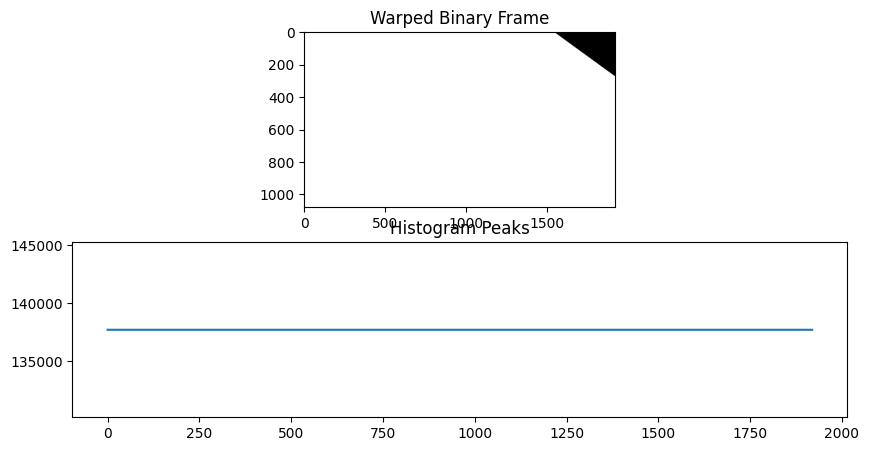

FPS: 0.65, Steering: 0.18, Speed: 0.56
Screen capture error: '_thread._local' object has no attribute 'srcdc'


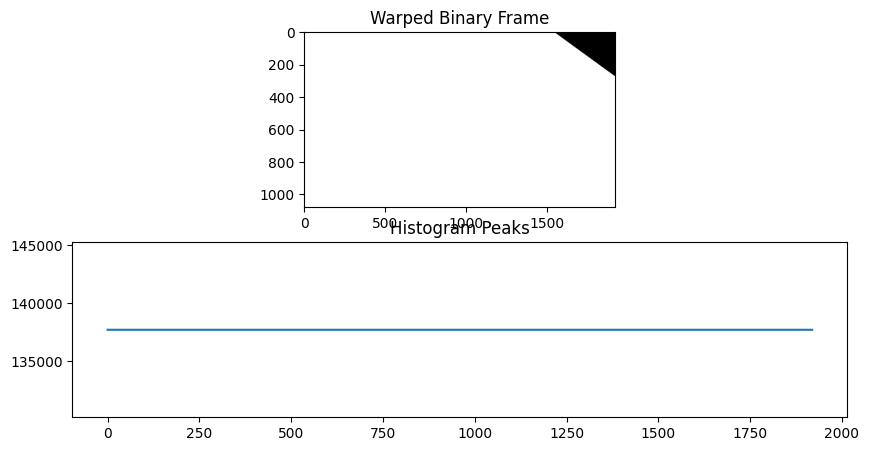

Screen capture error: '_thread._local' object has no attribute 'srcdc'


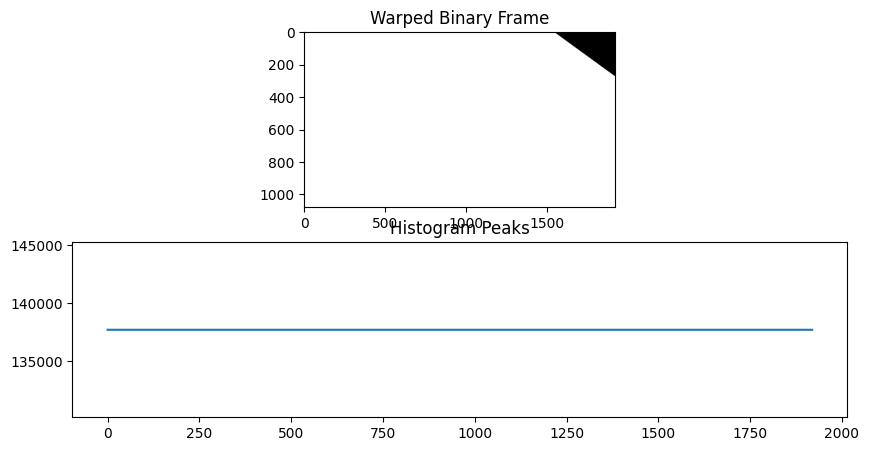

Screen capture error: '_thread._local' object has no attribute 'srcdc'


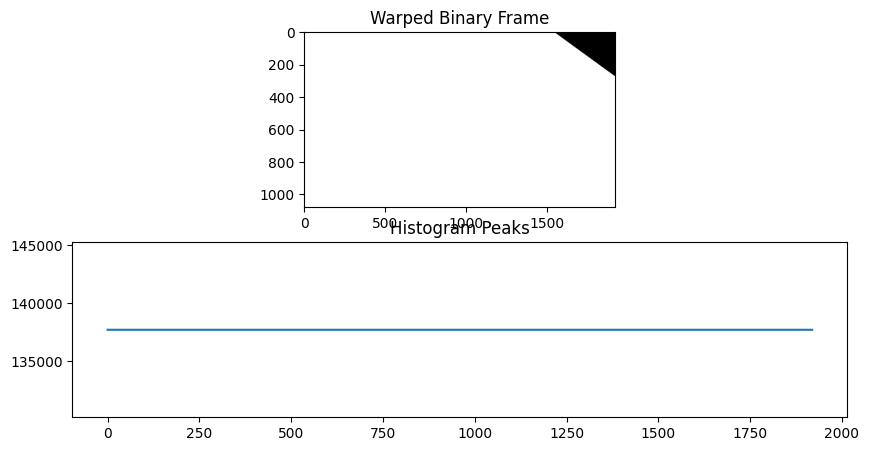

Screen capture error: '_thread._local' object has no attribute 'srcdc'


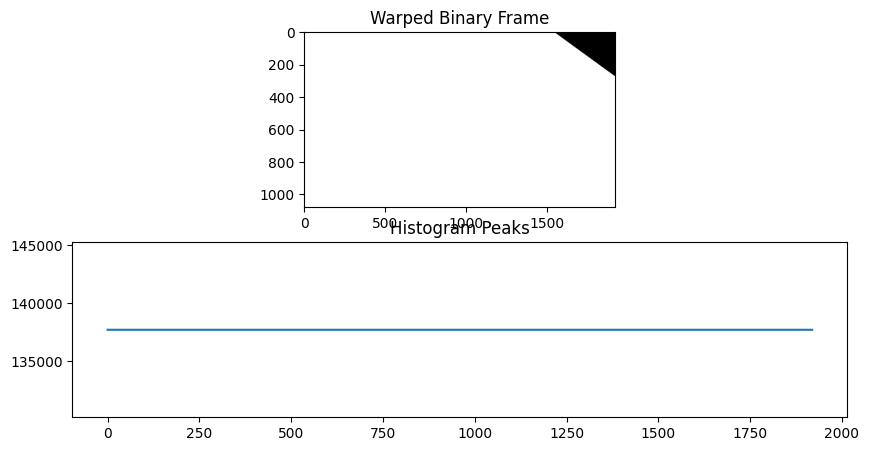

Screen capture error: '_thread._local' object has no attribute 'srcdc'


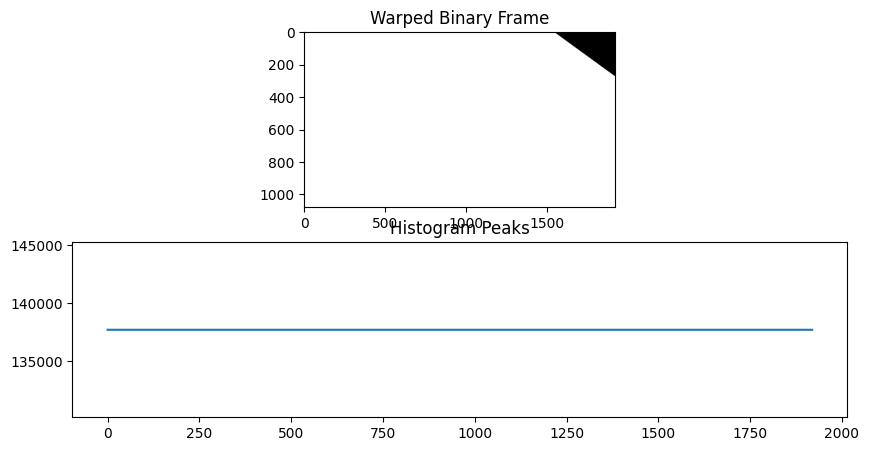

Screen capture error: '_thread._local' object has no attribute 'srcdc'


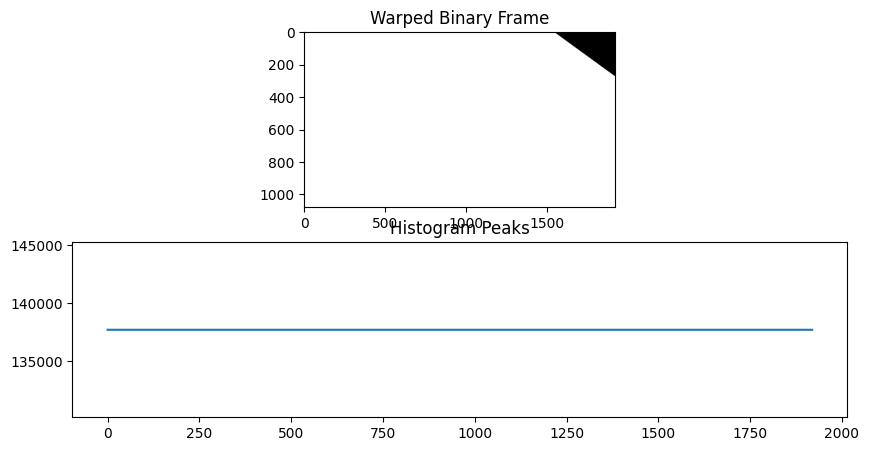

Screen capture error: '_thread._local' object has no attribute 'srcdc'


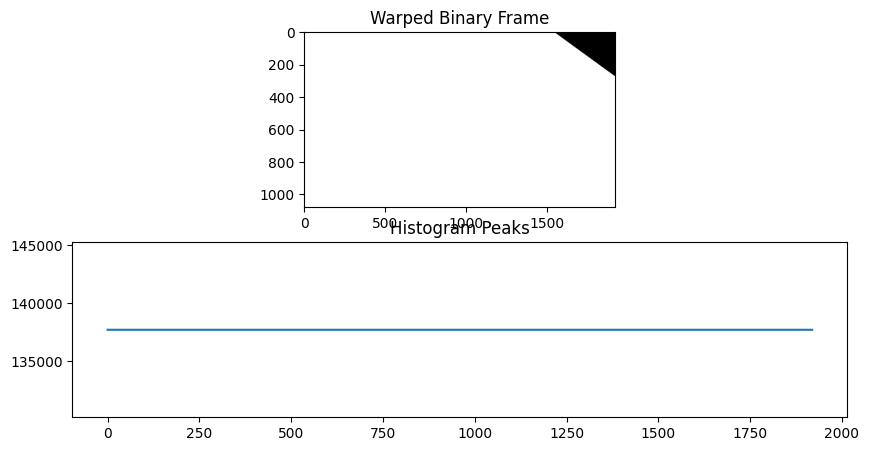

Screen capture error: '_thread._local' object has no attribute 'srcdc'


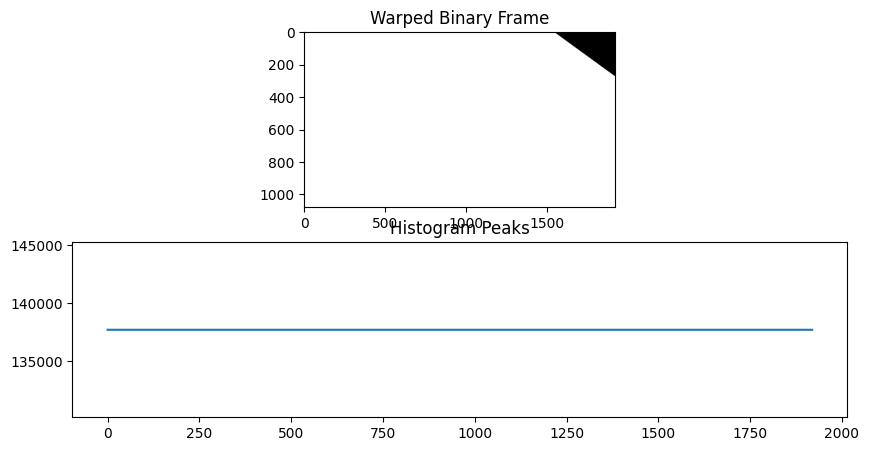

Screen capture error: '_thread._local' object has no attribute 'srcdc'


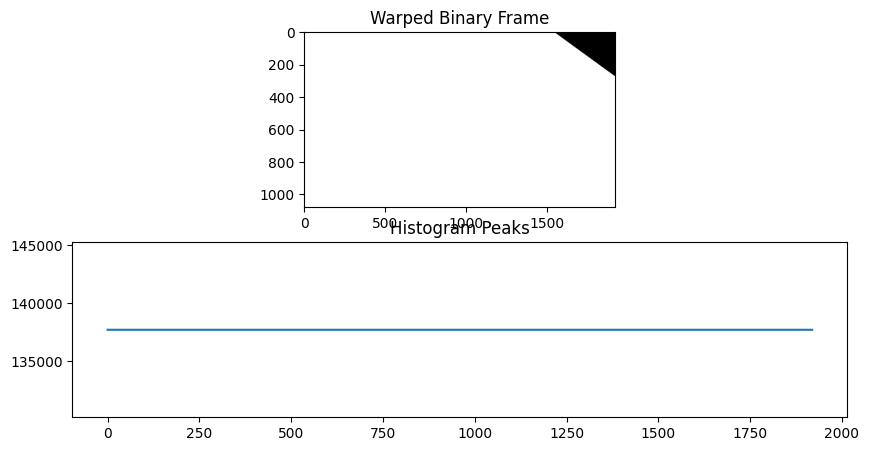

Screen capture error: '_thread._local' object has no attribute 'srcdc'


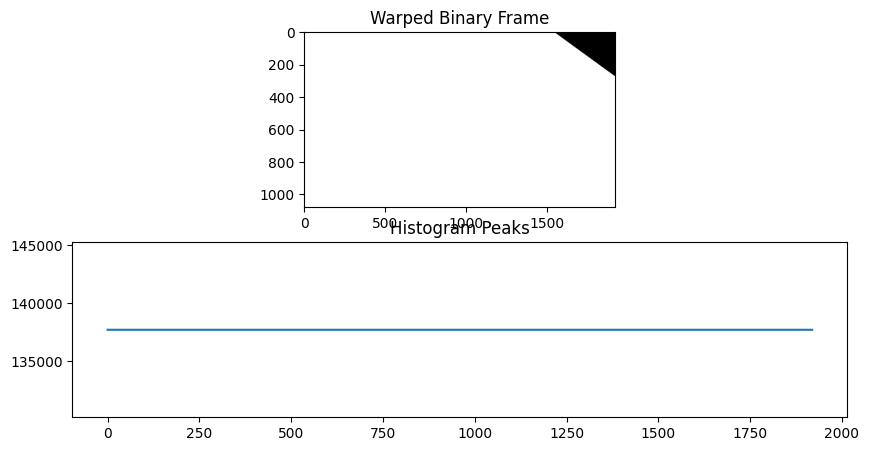

FPS: 0.64, Steering: 0.58, Speed: 0.56
Screen capture error: '_thread._local' object has no attribute 'srcdc'


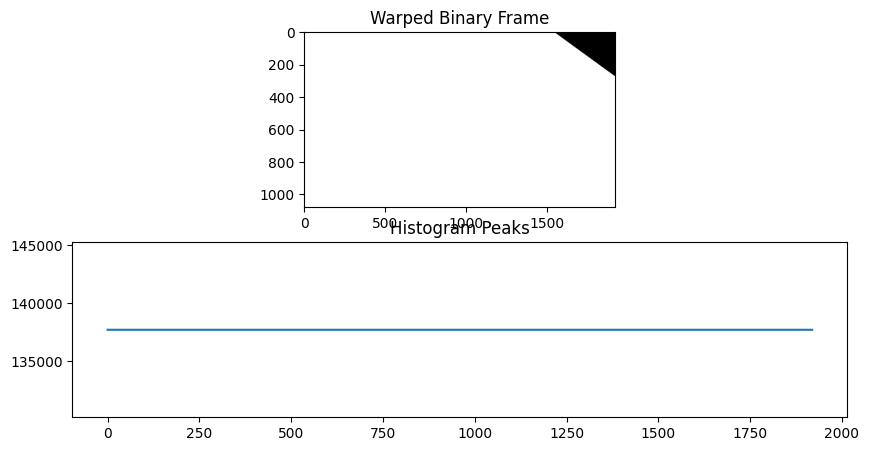

Screen capture error: '_thread._local' object has no attribute 'srcdc'


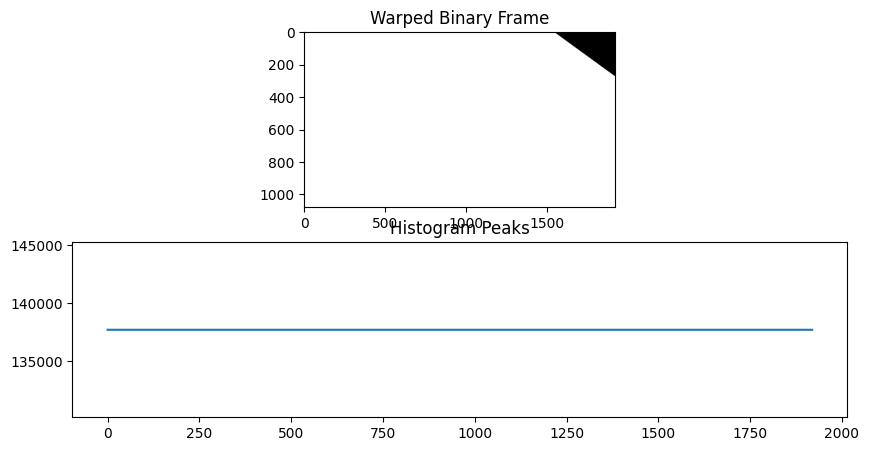

Screen capture error: '_thread._local' object has no attribute 'srcdc'


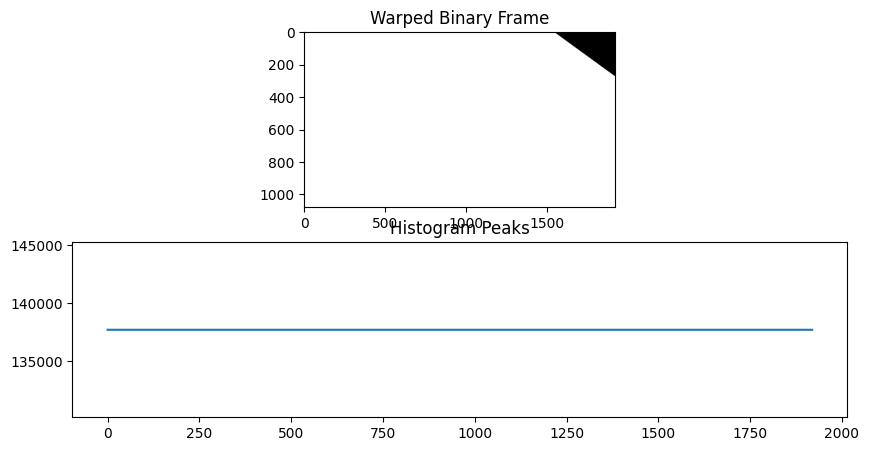

Screen capture error: '_thread._local' object has no attribute 'srcdc'


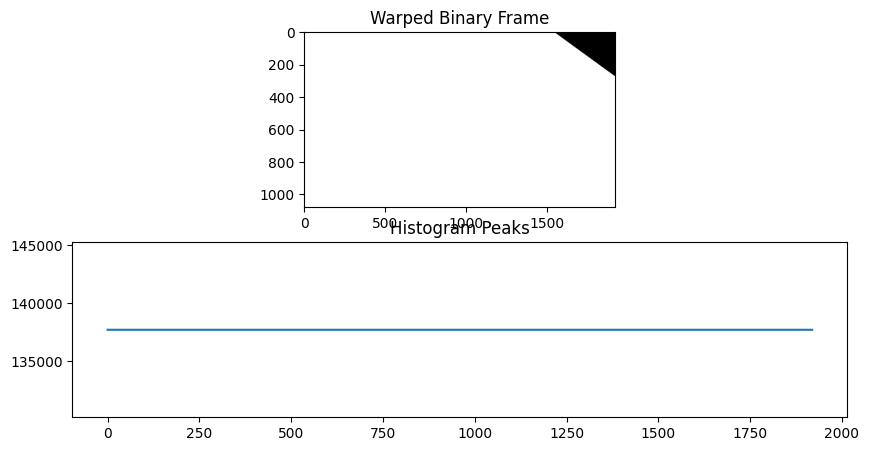

Screen capture error: '_thread._local' object has no attribute 'srcdc'


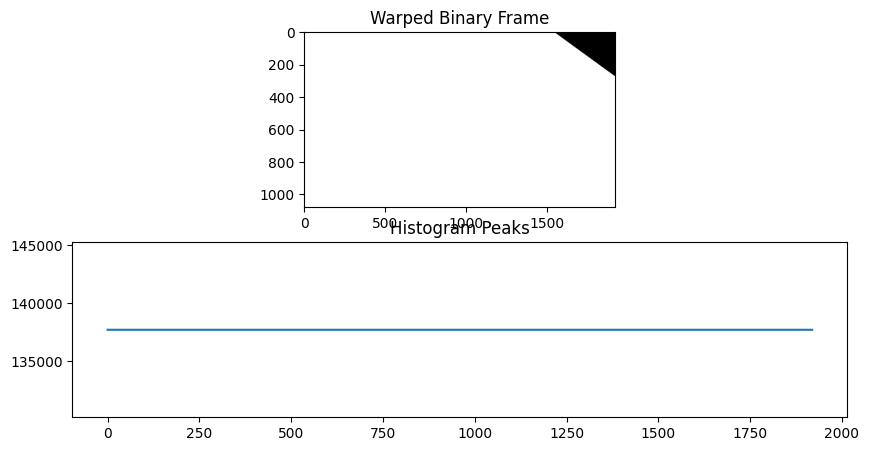

Screen capture error: '_thread._local' object has no attribute 'srcdc'


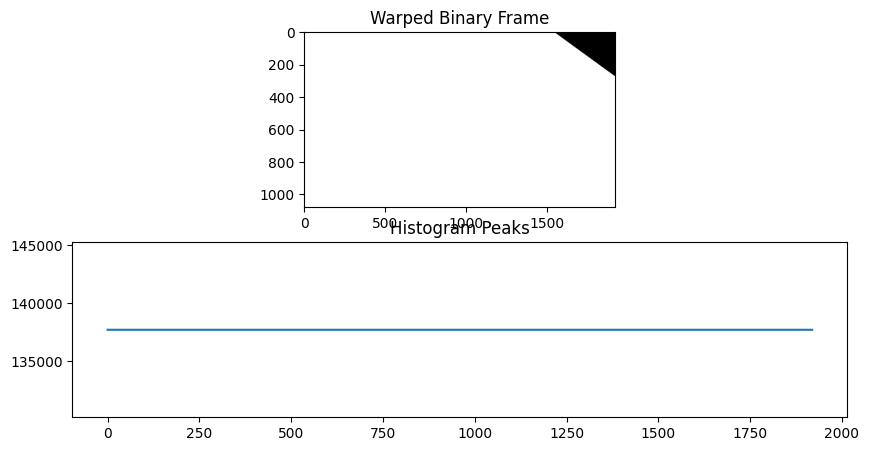

Screen capture error: '_thread._local' object has no attribute 'srcdc'


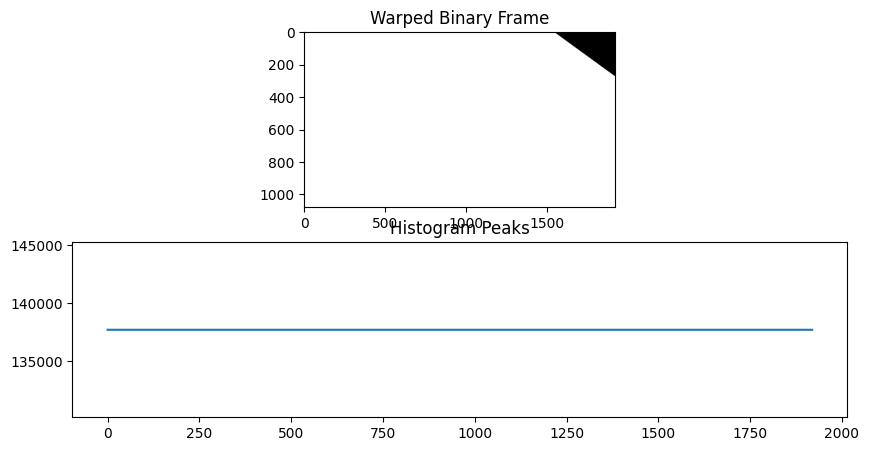

Autonomous driving stopped


In [ ]:
# %pip install pydirectinput
import time
import pydirectinput

print("Testing inputs in 3 seconds...")
time.sleep(2)
pydirectinput.keyDown('w')
time.sleep(3)
pydirectinput.keyUp('w')
print("Did the car move forward?")